In [1]:
!pip install GPy

In [0]:
import GPy
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import multivariate_normal


In [0]:
#tanh is applied to get basis component for the non linear component, but only make_basis_linear_periodic_tanh function below is used.

#Infer weight from data
def getw(x, y):
  X_pseudo_inverse = np.dot(np.linalg.inv(np.dot(x.T,x)), x.T)
  w_in = np.dot(X_pseudo_inverse, y)
  return w_in

#Function with periodic and nonlinear only
def make_basis_periodic_tanh(x,y):
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),periodic, tanh_calculated]) 

#Function with nonlinear only
def make_basis_tanh(x,y):
    
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)), tanh_calculated]) 

#Function with linear and nonlinear only
def make_basis_linear_tanh(x,y):
    
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),x, tanh_calculated]) 

#Function with linear, periodic and nonlinear only
def make_basis_linear_periodic_tanh(x,y):
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    w0 = np.ones((x.shape[0],1))
    tanh_calculated = np.tanh(w0 + x*getw(x,y))
    return np.hstack([np.ones((x.shape[0],1)),x, periodic, tanh_calculated]) 

#test function
def test(x,y,plot=False):   
  H = make_basis_tanh(x.reshape(-1,1), y)
  return H



In [0]:
#Original basis functions
def make_basis(x):
 
    periodic = np.hstack([np.cos(2*np.pi*x),np.sin(2*np.pi*x),np.cos(4*np.pi*x),np.sin(4*np.pi*x),np.cos(6*np.pi*x),np.sin(6*np.pi*x),np.cos(8*np.pi*x),np.sin(8*np.pi*x),np.cos(10*np.pi*x),np.sin(10*np.pi*x),np.cos(12*np.pi*x),np.sin(12*np.pi*x)])
    return np.hstack([np.ones((x.shape[0],1)),x, periodic ]) 


In [0]:
col_per = 2

#In this function the approach is tried where it checks if the sample lines (straight ones) cross the 
#mean function, if just once or below then it is considered linear function
def run_model(x,y,functype, plot=False): 
    #Call basis function for various functype variable value. But this function is always called with value 0
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    H_np = H[:,0:col_per]
    

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    
    print(np.mean(posterior['weights'],axis=0))
    v=posterior
    all_prediction = np.dot(H,posterior['weights'].T).T
    
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T
    
    
    if plot==True:
        plt.figure(figsize=(10,8))
        #plt.plot(x,all_prediction[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,non_periodic_prediction[0:100,:].T,'b', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)

    lnear=0
    
    #Find no of intersections beween periodic and linear, for base code the lines cross 4 times, this would change with the competition data, the limit will have to be decided  
    #Here just thinking that one of the sample lines just intersepting the mean function just once
    for j in range(non_periodic_prediction.shape[0]):
      idx1 = np.argwhere(np.diff(np.sign(np.mean(all_prediction,axis=0) - non_periodic_prediction[j,]))).flatten()
      if (idx1.shape[0]<=1):
        lnear=1
        print('Got one with just single or 0 intersection which is very less ')
        break
    
       
    Gradients = []

    if(lnear!=1):
      print('Linear - all to be used for gradient calculation')
      for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
    else:
      print('periodic - non linear to be used for gradient calculation')
      for i in range(non_periodic_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
    
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    
   
    if posterior_probability_deriviative_is_positive>0.95:
      print(1)
      return 1
    else:
      print(0)
      return 0
    


In [0]:
#In this function the approach is tried where it gets all components - linear, periodic, non linear
#The function below just checks which one is convenient

col_per = 2

#baseline model - right now its working on original basis function only
def run_model1(x,y,functype, plot=False): 
    
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    print(H.shape)
    #select non periodic components of the basis
    #with non linear basis functions and various combinations this will have to be looked at or there would be more H variables
    H_npl = H[:,0:col_per]
    H_p = H[:,col_per:15]
    H_nl = H[:,15:16]

    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    all_prediction = np.dot(H,posterior['weights'].T).T
    
    prediction_npl = np.dot(H_npl,posterior['weights'][:,0:col_per].T).T
    
    prediction_p = np.dot(H_p,posterior['weights'][:,col_per:15].T).T
    
    prediction_nl = np.dot(H_nl,posterior['weights'][:,15:16].T).T
    
    if plot==True:
        plt.figure(figsize=(20,10))
        plt.plot(x,prediction_npl[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(prediction_npl,axis=0),'g', label='Linear Mean')
        plt.plot(x,np.mean(prediction_p,axis=0),'b', label='periodic Mean')
        plt.plot(x,np.mean(prediction_nl,axis=0),'y', label='Mean of the nonlinear comp.')
        plt.legend()
        plt.scatter(x,yn)
  
   
    print('all predictions')
    Gradients = []
    for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
        
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('Linear predictions')
    Gradients1 = []
    for i in range(prediction_npl.shape[0]):
          Gradients1.append(np.min(np.gradient(prediction_npl[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients1)>0)[0])/len(Gradients1)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('Periodic predictions')
    Gradients2 = []
    for i in range(prediction_p.shape[0]):
          Gradients2.append(np.min(np.gradient(prediction_p[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients2)>0)[0])/len(Gradients2)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    print('nonlinear predictions') 
    Gradients3 = []
    for i in range(prediction_nl.shape[0]):
          Gradients3.append(np.min(np.gradient(prediction_nl[i,:], x)))
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients3)>0)[0])/len(Gradients3)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
    if posterior_probability_deriviative_is_positive>0.95:
        print(1)
    else:
        print(0)
        
    return 


In [0]:
#In this function the approach is tried where it checks if the mean linear function crosses the 
#mean overall function

col_per = 2

def run_model2(x,y,functype, plot=False): 
    
    if (functype ==0):
      H = make_basis(x.reshape(-1,1))
    elif (functype ==1):
      H = make_basis_linear_periodic_tanh(x.reshape(-1,1),y)
    elif (functype ==2):
      H = make_basis_linear_tanh(x.reshape(-1,1),y)
    elif (functype ==3):
      H = make_basis_tanh(x.reshape(-1,1),y)
    elif (functype ==4):
      H = make_basis_periodic_tanh(x.reshape(-1,1),y)
      
    #normalize the data
    yn = (y-np.mean(y))/np.std(y)
    
    #select non periodic components of the basis
    #with non linear basis functions and various combinations this will have to be looked at or there would be more H variables
    H_np = H[:,0:col_per]


    with pm.Model() as model:
        #prior
        w = pm.Normal('weights', mu=0, sd=50, shape=(H.shape[1],))
        sigma = pm.HalfCauchy('sigma', 5)

        #linear model
        mu = pm.Deterministic('mu', pm.math.matrix_dot(H,w).T)

        #likelihood
        y_obs = pm.Normal('y', mu=mu, sd=sigma, observed=yn)

        #we can do  an approximated inference
    with model:
        inference = pm.ADVI()
        approx = pm.fit(60000, method=inference)
        
    posterior = approx.sample(draws=500)
    
    #could the strength of these be deciding factor which one to go for?
    #note the peridic basis also works with non linear, so its misleading
    
    print(np.mean(posterior['weights'],axis=0))

    all_prediction = np.dot(H,posterior['weights'].T).T
    
    non_periodic_prediction = np.dot(H_np,posterior['weights'][:,0:col_per].T).T

    if plot==True:
        plt.figure(figsize=(10,8))
        #plt.plot(x,all_prediction[0:100,:].T,'r', alpha=0.05)
        plt.plot(x,non_periodic_prediction[0:100,:].T,'b', alpha=0.05)
        plt.plot(x,np.mean(all_prediction,axis=0),'r', label='Overall Mean')
        plt.plot(x,np.mean(non_periodic_prediction,axis=0),'b', label='Mean of the non-periodic comp.')
        plt.legend()
        plt.scatter(x,yn)

       
    
   

    idx = np.argwhere(np.diff(np.sign(np.mean(all_prediction,axis=0) - np.mean(non_periodic_prediction,axis=0)))).flatten()
    print('intersections',idx.shape[0])
    
    Gradients = []
   
    
     
    if(idx.shape[0]<5):
      print('linear - all to be used for gradient calculation')
      for i in range(all_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(all_prediction[i,:], x)))
    else:
      print('periodic - non linear to be used for gradient calculation')
      for i in range(non_periodic_prediction.shape[0]):
          Gradients.append(np.min(np.gradient(non_periodic_prediction[i,:], x)))
    
  
    posterior_probability_deriviative_is_positive = len(np.where(np.array(Gradients)>0)[0])/len(Gradients)
    print('posterior_probability_deriviative_is_positive', posterior_probability_deriviative_is_positive)
  
    if posterior_probability_deriviative_is_positive>0.95:
        return 1
    else:
        return 0
   

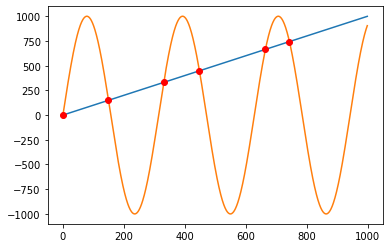

6

In [36]:
#Check how to get the no of intersections 
x = np.arange(0, 1000)
f = np.arange(0, 1000)
g = np.sin(np.arange(0, 10, 0.01) * 2) * 1000

plt.plot(x, f, '-')
plt.plot(x, g, '-')

idx = np.argwhere(np.diff(np.sign(f - g))).flatten()
plt.plot(f[idx], f[idx], 'ro')
plt.show()
idx.shape[0]

In [0]:
#read data
data = pd.read_csv('https://gitlab.com/vsambhe1/machine-learning-competition/raw/master/train.csv')

Average Loss = 222.61: 100%|██████████| 60000/60000 [00:50<00:00, 1186.41it/s]
Finished [100%]: Average Loss = 222.61


[-0.45176863  0.93872115  0.15926299  0.32976407  0.02160984  0.12325914
  0.07913834  0.27236262  0.16964309  0.12329756  0.0782491  -0.04493224
 -0.06827371  0.29688189]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

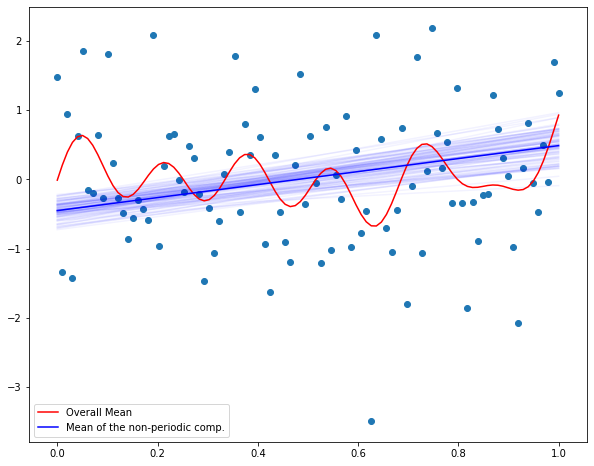

In [89]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model(X,Y,0,plot=True) 

Result above is correct

(100, 15)


Average Loss = 228.54: 100%|██████████| 60000/60000 [00:51<00:00, 1167.39it/s]
Finished [100%]: Average Loss = 228.54


all predictions
posterior_probability_deriviative_is_positive 0.0
0
Linear predictions
posterior_probability_deriviative_is_positive 1.0
1
Periodic predictions
posterior_probability_deriviative_is_positive 0.0
0
nonlinear predictions
posterior_probability_deriviative_is_positive 0.0
0


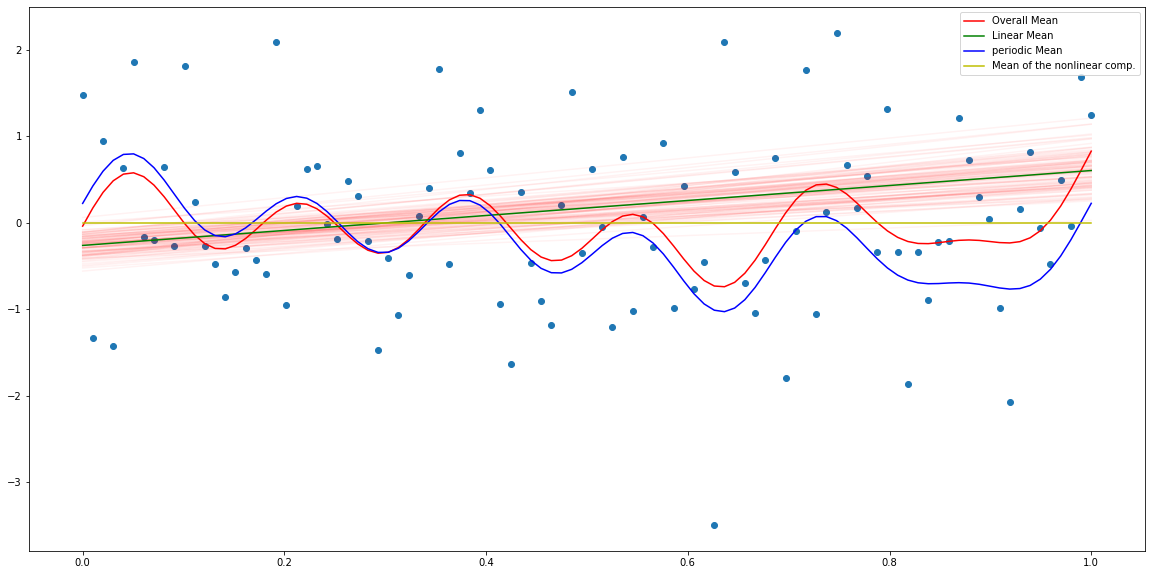

In [90]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model1(X,Y,1,plot=True)  

Average Loss = 222.52: 100%|██████████| 60000/60000 [00:50<00:00, 1177.15it/s]
Finished [100%]: Average Loss = 222.51


[-0.46657202  0.9232034   0.16263885  0.32748044  0.02584627  0.11937279
  0.07161283  0.26050766  0.1766666   0.13364893  0.08182093 -0.04167214
 -0.09382886  0.30821952]
intersections 8
periodic - non linear to be used
posterior_probability_deriviative_is_positive 1.0


1

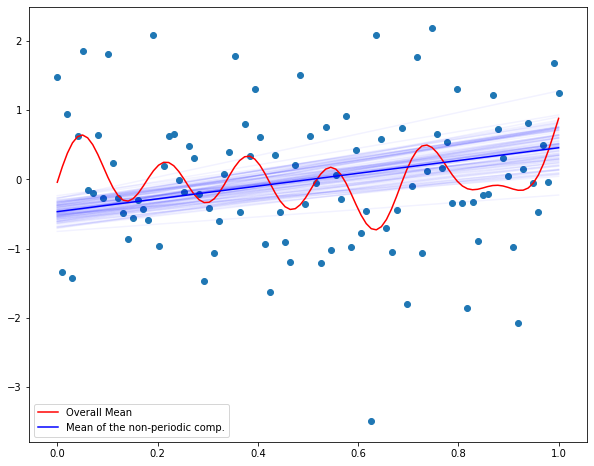

In [91]:
X = np.linspace(0,1,100)

Y = data.iloc[0,1:101].values
run_model2(X,Y,0,plot=True)   

Model 2 approach not working , above result is wrong

Average Loss = 193.75: 100%|██████████| 60000/60000 [00:49<00:00, 1212.90it/s]
Finished [100%]: Average Loss = 193.75


[-0.26844848  0.50408255  0.01715705 -0.5126943   0.09224035 -0.1779825
  0.66517118 -0.1438476  -0.05866902 -0.06129332  0.16840965 -0.10865085
  0.04118973 -0.0840291 ]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

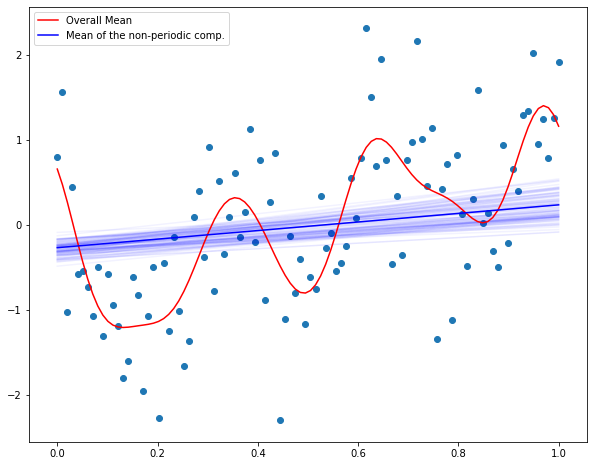

In [92]:
X = np.linspace(0,1,100)

Y = data.iloc[3,1:101].values
run_model(X,Y,0,plot=True) 

The result is correct above, lets try 4th and 15th

Average Loss = 166.91: 100%|██████████| 60000/60000 [00:50<00:00, 1192.89it/s]
Finished [100%]: Average Loss = 166.9


[-0.95328798  1.89844645  0.29087363 -0.33777537  0.03540899 -0.1302614
  0.0698685  -0.07311064 -0.00467442 -0.13501356 -0.1134273  -0.13414199
  0.11149841 -0.01213484]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

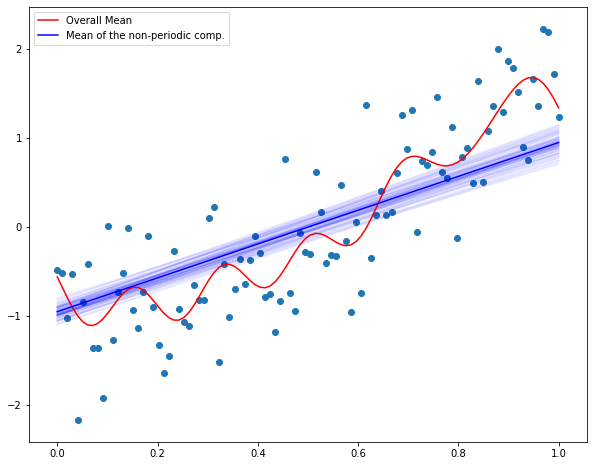

In [93]:
X = np.linspace(0,1,100)

Y = data.iloc[4,1:101].values
run_model(X,Y,0,plot=True) 

Average Loss = 125.06: 100%|██████████| 60000/60000 [00:50<00:00, 1191.16it/s]
Finished [100%]: Average Loss = 125.06


[-1.4317369   2.86816576  0.33947235 -0.10436485 -0.16225764 -0.06598967
  0.0646153  -0.00957709 -0.02098383 -0.03475858  0.04047892  0.00431619
  0.0436455   0.02935559]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


0

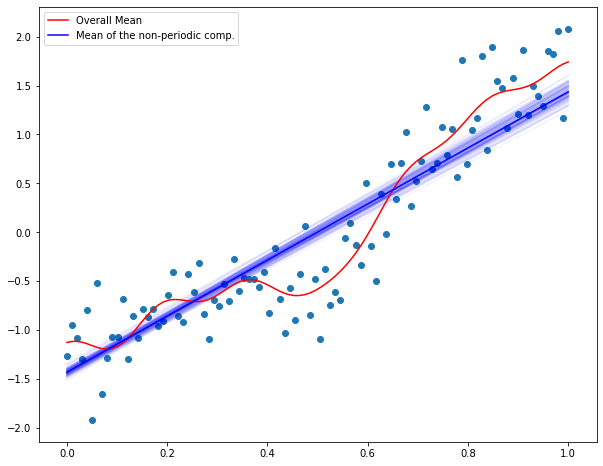

In [94]:
X = np.linspace(0,1,100)

Y = data.iloc[15,1:101].values
run_model(X,Y,0,plot=True) 

The results above are wrong

In [0]:
from google.colab import files
test_df = pd.read_csv('https://gitlab.com/vsambhe1/machine-learning-competition/raw/master/test.csv')
x = np.linspace(0,1,100)
Decision = pd.DataFrame(columns=['Id','Category'])
# train_df.shape[0]
for r in range(test_df.shape[0]):
    id_row = test_df.iloc[r,0]
    y = test_df.iloc[r,1:101].values
    d = run_model(x,y,0,plot=True) 
    
    Decision = Decision.append({'Id': int(id_row), 'Category': int(d)}, ignore_index=True)
  
  
output_file = Decision.to_csv('submission_1.csv')

	
files.download(output_file)

Average Loss = 127.77: 100%|██████████| 60000/60000 [00:49<00:00, 1203.87it/s]
Finished [100%]: Average Loss = 127.76


[-1.62967958e+00  3.26223768e+00 -3.61966436e-02 -2.02328102e-03
 -1.46443908e-02  1.72331277e-02 -7.10832359e-02 -9.74462660e-03
  1.56134435e-02  6.59871939e-02 -2.27347872e-02 -1.89001635e-02
 -1.62099554e-02  7.77067989e-02]
Linear - all to be used for gradient calculation


Average Loss = 201.76: 100%|██████████| 60000/60000 [00:52<00:00, 1152.78it/s]
Finished [100%]: Average Loss = 201.76


posterior_probability_deriviative_is_positive 0.002
0
[-0.86465044  1.74830253  0.30606479  0.04372599 -0.31814488  0.00832043
  0.11765162 -0.11739781 -0.1228634  -0.04845935  0.1408878   0.01179866
 -0.17887188 -0.20732271]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 212.01: 100%|██████████| 60000/60000 [00:51<00:00, 1171.72it/s]
Finished [100%]: Average Loss = 212.01


[-0.5315782   1.05545472  0.29279145 -0.11826815 -0.1028106   0.10351546
  0.283384   -0.17319652  0.01458085 -0.10447851  0.07782048  0.11801196
 -0.19425982  0.03032086]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 216.77: 100%|██████████| 60000/60000 [00:50<00:00, 1188.35it/s]
Finished [100%]: Average Loss = 216.76


[-0.27725813  0.58758724 -0.26874129  0.080505    0.05759575  0.32482311
 -0.31534719  0.01746935 -0.23044449 -0.11366123  0.31723549  0.00363488
 -0.13641559  0.11678555]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 116.61: 100%|██████████| 60000/60000 [00:49<00:00, 1210.99it/s]
Finished [100%]: Average Loss = 116.6


[-1.39225423e+00  2.78185241e+00  5.80534883e-01 -4.00316885e-02
 -3.11875684e-01 -2.11224847e-02  1.57853406e-01  2.00071813e-03
 -5.35048088e-03  7.78862705e-02  6.72514528e-02 -1.54121686e-02
 -1.56675112e-02 -2.79130432e-02]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 102.02: 100%|██████████| 60000/60000 [00:49<00:00, 1206.16it/s]
Finished [100%]: Average Loss = 102.02


[-1.46731856  2.91601874  0.28804063  0.00612462  0.06108269 -0.01564328
  0.58631878  0.04979346 -0.01547074 -0.03843308  0.05604011 -0.01423811
  0.01089878  0.03551801]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 174.41: 100%|██████████| 60000/60000 [00:50<00:00, 1198.71it/s]
Finished [100%]: Average Loss = 174.41


[-0.81708672  1.65962188  0.23906711 -0.37433856  0.18705094 -0.19003082
  0.13214818 -0.12350668 -0.09101363 -0.0914635   0.0481849  -0.21414838
  0.05200574 -0.02982502]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 216.82: 100%|██████████| 60000/60000 [00:51<00:00, 1175.87it/s]
Finished [100%]: Average Loss = 216.83


[-0.36487608  0.74646704 -0.14166855 -0.17647286  0.16765042 -0.12691969
 -0.16805876 -0.22326035 -0.02642863 -0.13179461 -0.01819153  0.03722719
 -0.00319546 -0.04027934]
Got one with just single or 0 intersection which is very less 
periodic - non linear to be used for gradient calculation
posterior_probability_deriviative_is_positive 1.0
1


Average Loss = 206.44: 100%|██████████| 60000/60000 [00:50<00:00, 1183.44it/s]
Finished [100%]: Average Loss = 206.44


[-0.45848551  0.92365687  0.15382911 -0.11856746  0.09471575 -0.03569516
  0.6551071  -0.02815311  0.15366394  0.05150803 -0.0856263   0.09805353
 -0.06226107 -0.14144772]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 57.45: 100%|██████████| 60000/60000 [00:50<00:00, 1190.76it/s]
Finished [100%]: Average Loss = 57.461


[-1.43294111e+00  2.86798006e+00 -2.51056471e-01 -2.96402590e-01
  3.31619308e-02  7.43122689e-01 -5.82107480e-03 -7.68161771e-03
  1.56380227e-03 -8.56038109e-03  7.42668291e-03  2.97923253e-02
 -1.87176882e-02  1.19734012e-02]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 126.79: 100%|██████████| 60000/60000 [00:50<00:00, 1182.49it/s]
Finished [100%]: Average Loss = 126.8


[-1.33533331e+00  2.67191630e+00  3.46799018e-01 -1.71375173e-01
 -2.00675635e-01 -6.19856717e-02  8.91373628e-02 -8.53275789e-02
 -1.08467720e-01  2.45641764e-02  1.47615837e-02  2.93061729e-02
  2.34372443e-03 -1.67078170e-02]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 174.73: 100%|██████████| 60000/60000 [00:50<00:00, 1199.78it/s]
Finished [100%]: Average Loss = 174.73


[-1.23067627e+00  2.47381375e+00  2.55041418e-01 -7.87472274e-02
 -2.20574043e-03  6.39144903e-02  3.55601725e-02 -8.86403209e-02
  1.37196275e-02 -1.76034398e-01  9.56013452e-02  3.65962588e-02
 -2.68955360e-03 -7.83204358e-02]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 109.49: 100%|██████████| 60000/60000 [00:50<00:00, 1198.68it/s]
Finished [100%]: Average Loss = 109.48


[-1.51529472e+00  3.02587349e+00  3.02263654e-01  3.78518658e-02
  3.69455933e-02  7.07519184e-02  6.19452290e-01  4.16295547e-02
  7.32109911e-03  3.00621953e-02  5.44558341e-02  2.47834382e-02
 -4.48608008e-05  8.62978661e-03]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 200.46: 100%|██████████| 60000/60000 [00:49<00:00, 1208.04it/s]
Finished [100%]: Average Loss = 200.47


[-0.12152595  0.21906248  0.03517661  0.11027516 -0.11346311  0.18104877
  0.89264197 -0.03967276 -0.13390675 -0.15129807  0.05797694  0.01925894
  0.0067898  -0.17136365]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 216.35: 100%|██████████| 60000/60000 [00:49<00:00, 1217.50it/s]
Finished [100%]: Average Loss = 216.35


[ 0.18680884 -0.41678148  0.38809976  0.12815126 -0.06524535 -0.02830285
  0.31038007 -0.16123935 -0.13547918 -0.18199524  0.0611719  -0.28903138
 -0.02141972 -0.00691941]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 222.8: 100%|██████████| 60000/60000 [00:51<00:00, 1169.16it/s]
Finished [100%]: Average Loss = 222.8


[-0.33340167  0.6532053   0.06087004 -0.11667284 -0.07305104 -0.06459784
  0.00535718  0.00174917  0.1702634   0.04802882  0.05823819  0.0075539
  0.10473195  0.06652326]
Got one with just single or 0 intersection which is very less 
periodic - non linear to be used for gradient calculation
posterior_probability_deriviative_is_positive 1.0
1


Average Loss = 204.58: 100%|██████████| 60000/60000 [00:51<00:00, 1153.90it/s]
Finished [100%]: Average Loss = 204.58


[-1.00589219  2.04064215  0.26545408  0.16848423 -0.10157012  0.00423893
  0.08368985 -0.00566397  0.07879044 -0.00418569  0.09771584 -0.10503783
 -0.21930502 -0.172928  ]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 190.83: 100%|██████████| 60000/60000 [00:52<00:00, 1139.60it/s]
Finished [100%]: Average Loss = 190.83


[-0.22417338  0.46018908 -0.06736554 -0.51349364  0.02258518 -0.07077984
  0.79661295 -0.05511866  0.05820302 -0.14637345 -0.00123974 -0.06555807
 -0.09191348  0.07567155]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 190.67: 100%|██████████| 60000/60000 [00:52<00:00, 1153.84it/s]
Finished [100%]: Average Loss = 190.67


[-9.93897730e-01  1.98647700e+00  1.85872256e-04  1.67865610e-02
 -3.30705544e-02 -5.26037275e-02  6.03696650e-01  7.50571219e-02
  1.25105946e-01 -1.00715570e-01 -1.81890665e-01  5.09142896e-02
  1.23163092e-01  9.53394634e-02]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 174.52: 100%|██████████| 60000/60000 [00:50<00:00, 1193.07it/s]
Finished [100%]: Average Loss = 174.53


[-1.24102538e+00  2.48099837e+00  2.43759019e-01 -1.81913247e-02
  1.97513660e-02 -9.76827124e-02  9.00382070e-03 -1.91914682e-01
  4.39254932e-02  1.10087297e-01  2.12568523e-03 -1.03451700e-01
 -5.12559081e-03 -6.28004432e-02]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 197.97: 100%|██████████| 60000/60000 [00:50<00:00, 1192.67it/s]
Finished [100%]: Average Loss = 197.97


[-0.87763605  1.74988682 -0.05297203  0.36669518 -0.08770377  0.18228122
  0.86636487  0.01915328  0.11688425 -0.03543951 -0.09077794  0.13611331
 -0.00398957 -0.06021229]
Linear - all to be used for gradient calculation


 /usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:54: RuntimeWarning:More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 212.18: 100%|██████████| 60000/60000 [00:50<00:00, 1194.03it/s]
Finished [100%]: Average Loss = 212.17


[-0.40043959  0.81238408  0.49850648  0.28920004 -0.32990979  0.23234894
  0.16572788 -0.03069296 -0.2155025   0.07947834  0.10161513 -0.13078856
  0.20799109 -0.17207971]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 214.18: 100%|██████████| 60000/60000 [00:48<00:00, 1224.89it/s]
Finished [100%]: Average Loss = 214.17


[ 0.13248651 -0.25441329 -0.06043855 -0.2053755   0.08719733  0.00648029
  0.67994454  0.07040262 -0.04405492  0.01540723 -0.09135114 -0.18678356
  0.05906636  0.08880587]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 201.72: 100%|██████████| 60000/60000 [00:50<00:00, 1193.61it/s]
Finished [100%]: Average Loss = 201.71


[-0.37983191  0.74334143  0.13684193 -0.2760744   0.00696666  0.12195294
  0.68844644  0.0200708   0.04122211  0.07035508  0.03970256 -0.16045711
 -0.22667187 -0.15691662]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 198.58: 100%|██████████| 60000/60000 [00:49<00:00, 1215.74it/s]
Finished [100%]: Average Loss = 198.58


[-0.57982344  1.14033291  0.12867888 -0.20344304  0.1604025  -0.12099995
  0.5969181  -0.08423501 -0.12228311 -0.11416925 -0.14641258  0.07015155
 -0.10378201 -0.04100467]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 224.53: 100%|██████████| 60000/60000 [00:48<00:00, 1233.45it/s]
Finished [100%]: Average Loss = 224.53


[ 0.09621557 -0.23191097 -0.06494973  0.00044607 -0.01830087 -0.10906541
  0.24171149 -0.13803013  0.12643783  0.09827031  0.05733613  0.10238201
  0.06160032  0.056635  ]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 198.41: 100%|██████████| 60000/60000 [00:49<00:00, 1222.26it/s]
Finished [100%]: Average Loss = 198.41


[-0.52574845  1.04335776 -0.11318613 -0.10073886  0.04554426 -0.05049155
  0.71690224 -0.18202887  0.16660043  0.02327191 -0.06933174 -0.09963525
 -0.0145679  -0.12252886]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 220.52: 100%|██████████| 60000/60000 [00:49<00:00, 1216.15it/s]
Finished [100%]: Average Loss = 220.51


[ 0.13450346 -0.23857541  0.03063685 -0.48185065 -0.06289006 -0.10626829
 -0.02219957 -0.1472733  -0.10786761 -0.20404294 -0.05780518 -0.23003412
  0.14457398 -0.13096242]
Linear - all to be used for gradient calculation
posterior_probability_deriviative_is_positive 0.0
0


Average Loss = 109.63:  63%|██████▎   | 37809/60000 [00:31<00:17, 1277.84it/s]